# MCMC Bayesian A/B Testing

In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/kazutak/Git/AB_test/.venv/bin/python
3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

あきらめて [Colabo](https://colab.research.google.com/drive/1vkHr3EQGtwwJJ6haHVxsxNglkuXv_XX6) へ

In [3]:
import pymc as pm

ImportError: cannot import name 'CompileError' from 'setuptools.errors' (/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/setuptools/errors.py)

poetry で pymc 環境を入れようとすると、コンパイル系でエラーがよく出るらしい<br>
conda 使えっていう助言あり、仕事で展開むずそうなので、一旦 Colab での実装を想定してすすめる 2023/10/07

In [28]:
thetas = np.linspace(0, 1, 1001)

likelihood = lambda r: thetas if r else (1 - thetas)

def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

In [4]:
# 一様分布を前提として、thetas の要素数で均等に値を分けてリスト化（確率の前提より 合計 = 1）
p = np.array([1 / len(thetas) for _ in thetas])

In [6]:
# 一度だけベイズ更新をしてみる
p_1 = posterior(1, p)

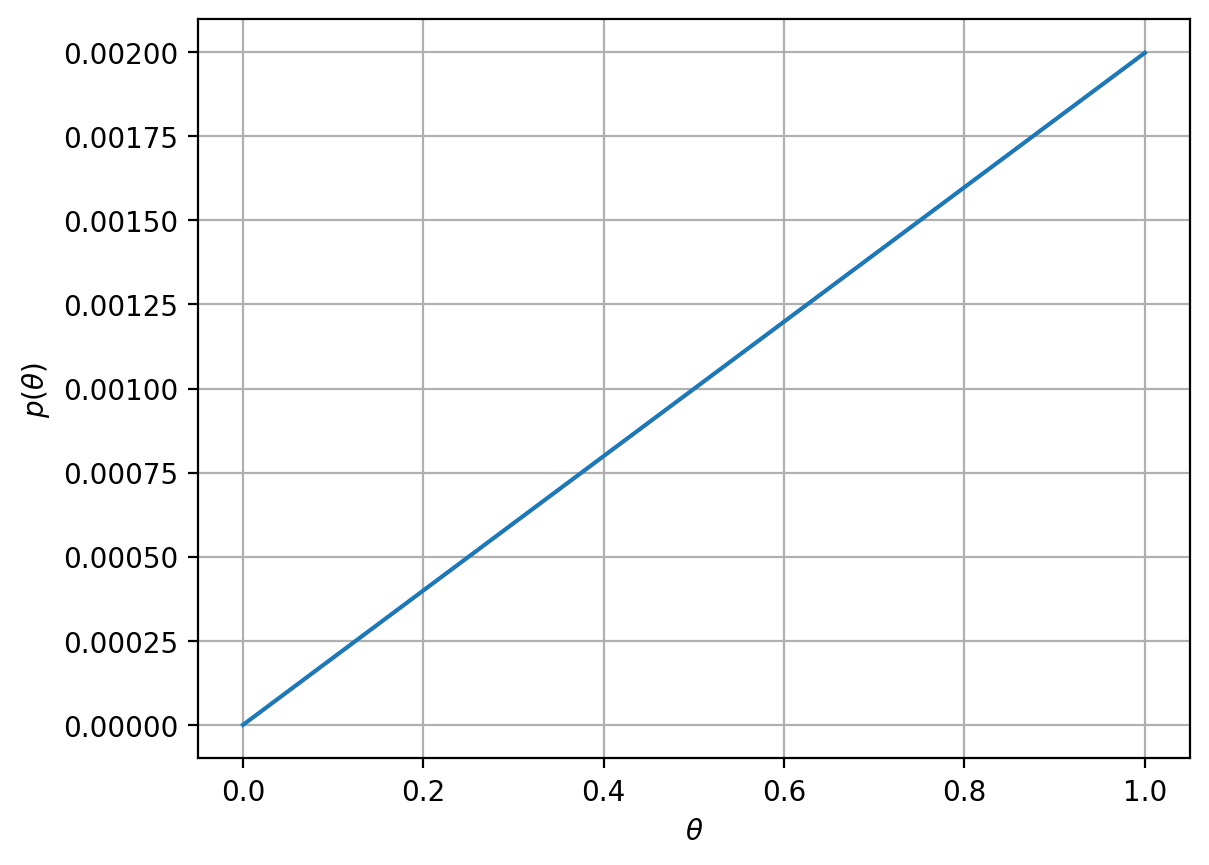

In [7]:
# 初期値
plt.plot(thetas, p_1)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.grid()
plt.show()

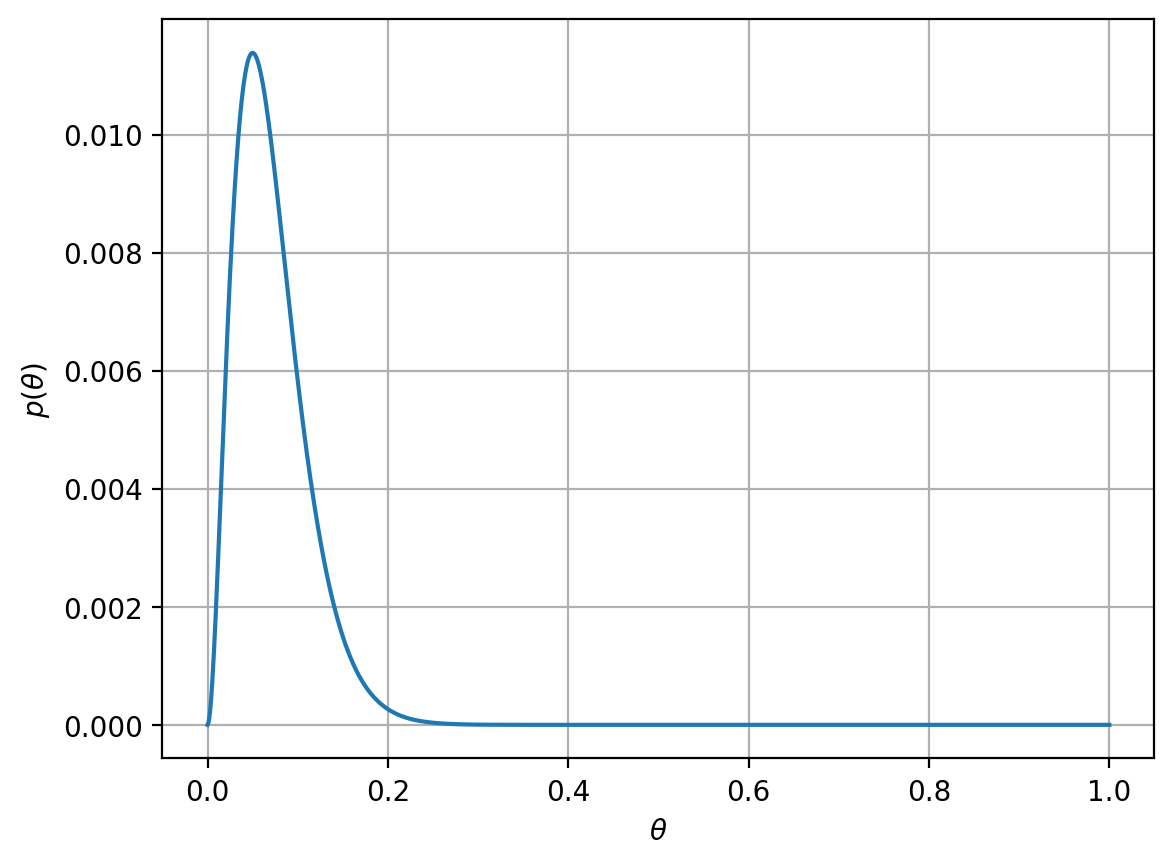

In [8]:
# Alice のレポート Aパターン にあるCV数、非CV数を元に”信念”をベイズ更新してみる
cv_cnt = 2
non_cv_cnt = 38

# 一様分布を前提として、thetas の要素数で均等に値を分けてリスト化（確率の前提より 合計 = 1）
p = np.array([1 / len(thetas) for _ in thetas])
for _ in range(cv_cnt):
    p = posterior(1, p)
for _ in range(non_cv_cnt):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.grid()
plt.show()

+ アリスとボブのレポートそれぞれに対して、一様分布からベイズ更新をかけていく
+ cv_cnt 分だけ posterior(1, p)
+ non_cv_cnt 分だけ posterior(0, p)

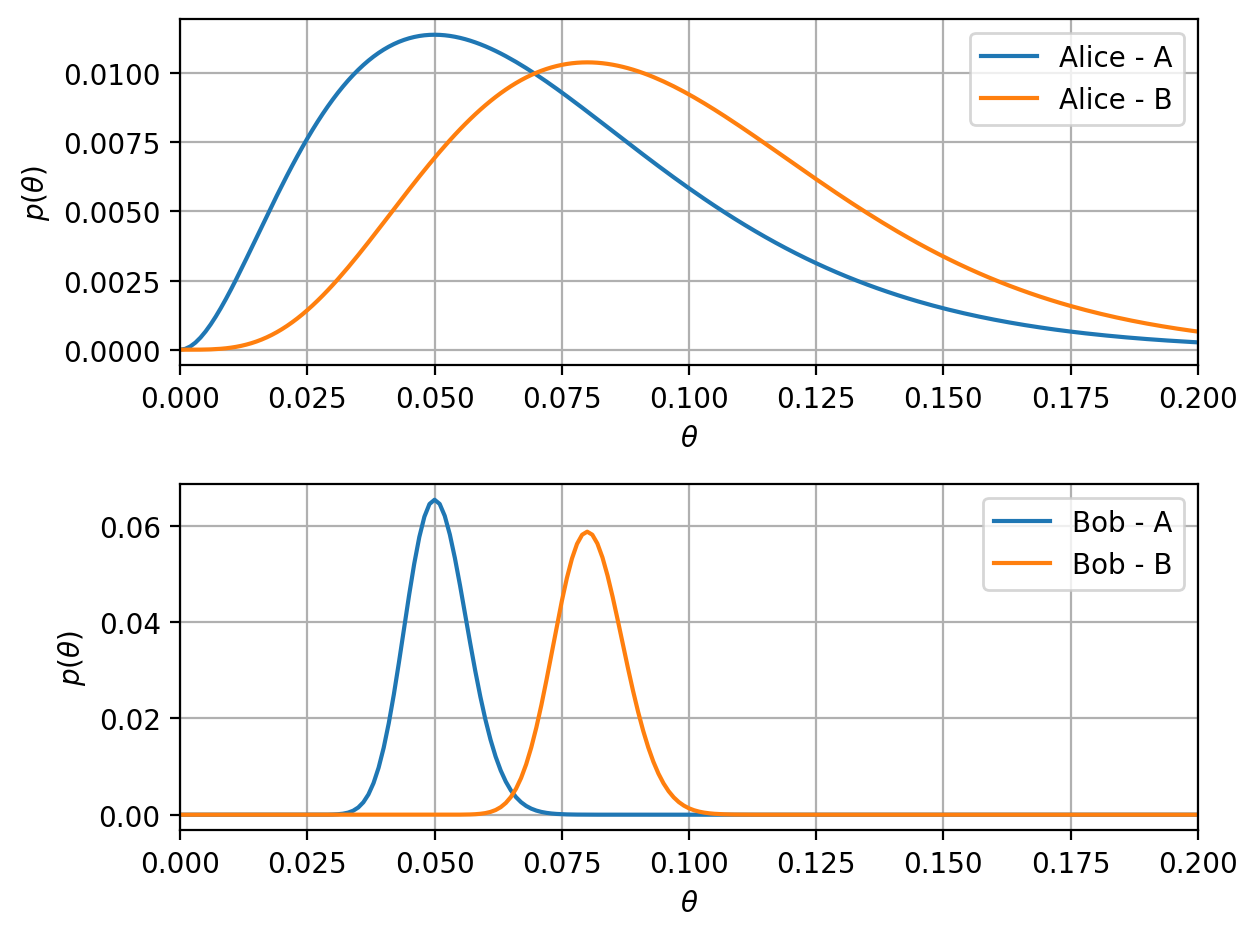

In [9]:
def draw(cv_cnt, non_cv_cnt, label):
  p = np.array([1 / len(thetas) for theta in thetas])
  for _ in range(cv_cnt):
    p = posterior(1, p)
  for _ in range(non_cv_cnt):
    p = posterior(0, p)
  plt.plot(thetas, p, label = label)
  
plt.subplot(2, 1, 1)
draw(2, 40 - 2, 'Alice - A')
draw(4, 50 - 4, 'Alice - B')
plt.xlim(0, 0.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
draw(64, 1280 - 64, 'Bob - A')
draw(128, 1600 - 128, 'Bob - B')
plt.xlim(0, 0.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
likelihood = lambda a, N: thetas ** a * (1 - thetas) ** (N - a)

In [11]:
def posterior(a, N, prior):
  lp = likelihood(a, N) * prior
  return lp / lp.sum()

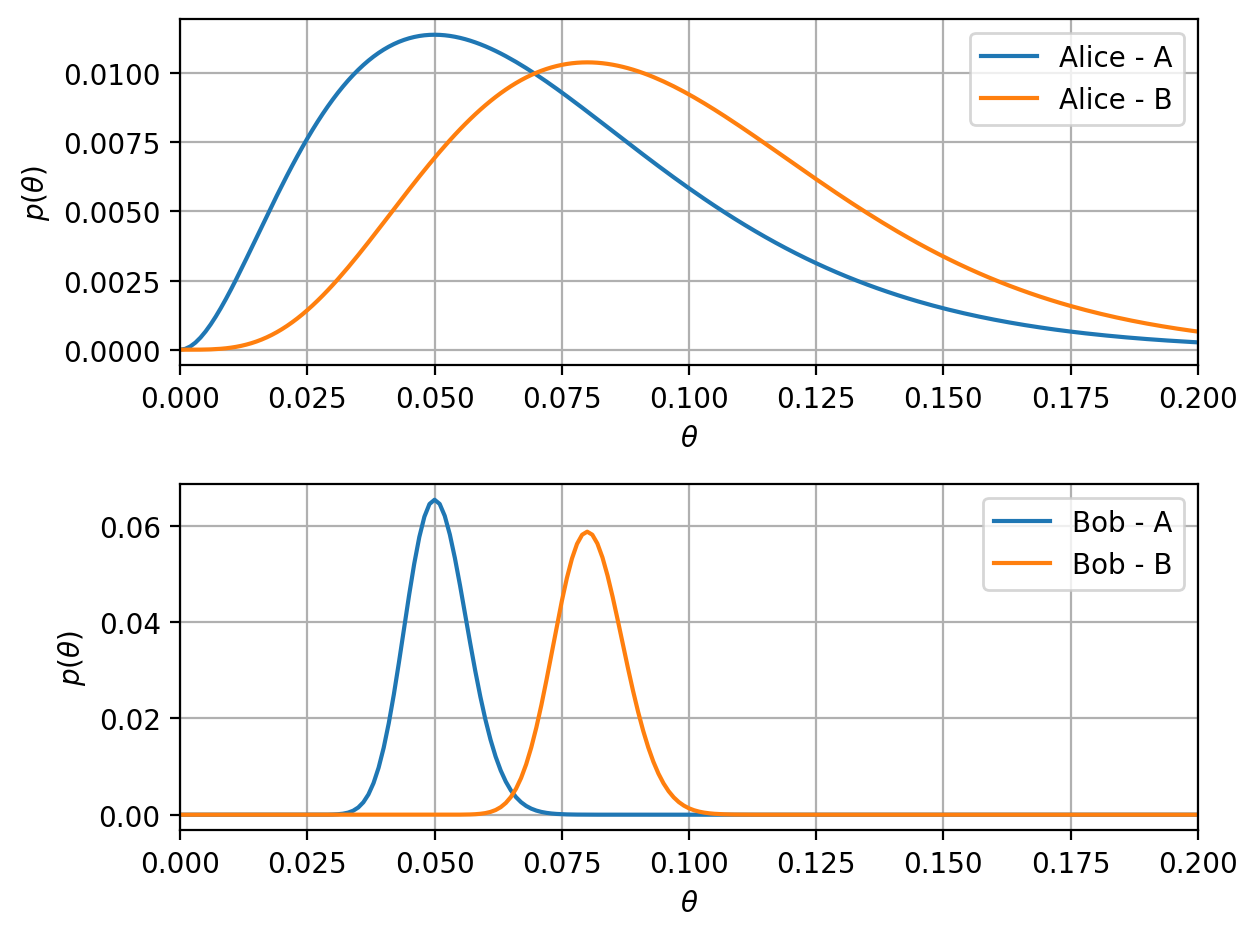

In [12]:
prior = 1 / len(thetas)
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40, prior), label='Alice - A')
plt.plot(thetas, posterior(4, 50, prior), label='Alice - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280, prior), label='Bob - A')
plt.plot(thetas, posterior(128, 1600, prior), label='Bob - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()